# Table of Contents
* &nbsp;
	* [0.1 imports](#0.1-imports)
	* [0.2 data](#0.2-data)
* [1. Submitting HITs- metric collection](#1.-Submitting-HITs--metric-collection)
	* [1.1 semantic qualtiy](#1.1-semantic-qualtiy)
	* [1.2 visual quality metric](#1.2-visual-quality-metric)
* [2. Retreive results](#2.-Retreive-results)
	* [2.1 consensus building](#2.1-consensus-building)
		* [2.1.1 code](#2.1.1-code)
		* [2.1.2 run](#2.1.2-run)
	* [2.2 recall](#2.2-recall)
		* [2.2.1 code](#2.2.1-code)
		* [2.2.2 run](#2.2.2-run)
	* [2.3 sanity check](#2.3-sanity-check)
	* [2.4 accept](#2.4-accept)
* [3. investigate quality bins](#3.-investigate-quality-bins)
	* [3.1 review gifs](#3.1-review-gifs)
		* [3.1.1 hide](#3.1.1-hide)
	* [3.2 metric proposal](#3.2-metric-proposal)
* [4. Hide](#4.-Hide)


## 0.1 imports

In [30]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
from tqdm import tqdm as tqdm
from collections import defaultdict
from collections import Counter

import xmltodict
import cv2
import PIL.Image as pil

import pickle
import boto3
import json
import os
from copy import deepcopy

from IPython.core.display import HTML

from keysTkingdom import mturk_ai2

from mturk.mturk import MTurk

import os
import random
import datetime

%load_ext autoreload
%autoreload 2

In [2]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

## 0.2 data

In [3]:
with open('./data/complete_dataset_3_3.pkl', 'rb') as f:
    complete_ds = pickle.load(f)

missing_pos = [v.gid() for v in complete_ds.data if 'pos_tags' not in  v.data()['parse']]

complete_ds.remove_vids(missing_pos)

with open('./easy_split_ids.json') as f:
    split_ids = json.load(f)

with open('./easy_split_len_hist.json') as f:
    easy_split_ids = json.load(f)

easy_split_ids.keys()

easy_val_sm = split_ids['easy_val_sm']
easy_val_lg = split_ids['easy_val_lg']

easy_val_lg_sep = [v for v in easy_val_lg if v not in easy_val_sm]

In [4]:
len(set(easy_val_lg).intersection(easy_val_sm))

24

In [5]:
data_path  = './gen_data/vis_query_val_db_train_stage1_16000_stage2_28000/'
gif_path = './gen_data/new_gifs/'
for f in os.listdir(data_path):
    if f.split('.')[0] in easy_val_lg:
        try:
            os.link(data_path + f, gif_path + f)
        except FileExistsError:
            pass

In [6]:
test_vid = random.choice(easy_val_lg)
vid = complete_ds.get_video(test_vid)
vid.description()

'Wilma and Betty are sitting on the couch and talking in the living room while both looking to the right.'

In [7]:
descs_sm = [complete_ds.get_video(v).description() for v in easy_val_sm if complete_ds.get_video(v)]

In [8]:
descs_lg = [complete_ds.get_video(v).description() for v in easy_val_lg_sep if complete_ds.get_video(v)]

In [9]:
descs_lens_sm = [len(d.split()) for d in descs_sm]
descs_lens_lg = [len(d.split()) for d in descs_lg]

In [10]:
# _ = pd.Series(descs_lens_sm).hist()

In [11]:
len(descs_lens_lg)

225

In [12]:
# vid.display_gif()

# 1. Submitting HITs- metric collection

## 1.1 semantic qualtiy

In [34]:
cat_headers = {
    'entities': 'Are any of the following people/places/things missing from the video?',
    'verbs': 'Do all of the actions highlighted in yellow take place in the video, and are the adjectives true?'
}

verb_blacklist = set(['is', 'are', 'was'])

def gen_template_args_from_datapoint(video, s3_base_path):        
    description = video.description()
    if description[-1] != '.':
        description += '.'
    description = description.replace('\'', '')
    formatted_description = [[word.encode('utf8').decode() for word in sent.split()] for sent in description.split('.')][:-1]
    
    vid_ents = [[c.data()['labelNPC']] for c in video.data()['characters'] + video.data()['objects']] + [[video.setting()]]
    vid_verbs = [word[0] for word in video.data()['parse']['pos_tags'] if word[1] in ['VBG', 'VBZ', 'VBP', 'JJ'] and word[0] not in verb_blacklist]
    vid_verbs.append('blue')
    ent_button_js = form_button_arr_js(vid_ents, [v[0] for v in vid_ents], ('entities', cat_headers['entities']))
    verb_button_js = form_button_arr_js(formatted_description, vid_verbs, ('verbs', cat_headers['verbs']))
    
    return {'image_id': video.gid(), 'verb_button_js': verb_button_js, 'ent_button_js': ent_button_js, 's3_base_path': s3_base_path}

def form_button_arr_js(buttons, active, category=None):
    if not buttons:
        return ''
    button_arr_js = f"<br><h4>{category[1]}</h4>"
    for i, sent in enumerate(buttons):
        button_arr_js += '<br>\n'
        for j, word in enumerate(sent):
            b_id = '_'.join(['_'.join(word.split()), str(i), str(j)])
            disabled = '' if word in active else 'disabled=true' 
            color = '#FFFF4C' if word in active else '' 
            button_arr_js += f"<input type='button' onclick=\"record_value('{category[0] + '__' + b_id}');\" value='{word}' id= '{category[0] + '__' + b_id}' {disabled}  style=background-color:{color} />"    
    button_arr_js += f"<br><input type='button' onclick=\"record_value('{category[0] + '__None'}');\" style=background-color:#ff0000 value='None Missing' id='{category[0] + '__None'}' />"
    return button_arr_js

In [35]:
pvid = 's_06_e_14_shot_021030_021104'
pvid = 's_04_e_08_shot_029353_029427'
pvid = 's_04_e_02_shot_011770_011844'
sample_vid = 's_06_e_18_shot_006963_007037'
prob_video = complete_ds.get_video(sample_vid)

In [218]:
mt_client.preview_hit_interface(template_params, **gen_template_args_from_datapoint(prob_video, client_params['s3_base_path']))

In [387]:
demo_vid = deepcopy(prob_video)

# for char in demo_vid.data()['characters']:
#     if char.data()['entityLabel'] == 'barney':
#         char.data()['entityLabel'] = 'wilma'
# demo_vid.data()['description'] = demo_vid.description().replace('Barney', 'Wilma')

demo_vid.data()['setting'] = 'kitchen'
# demo_vid.data()['characters'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').data()['characters']
# demo_vid.data()['objects'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').data()['objects']
# demo_vid.data()['parse'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').data()['parse']

# demo_vid.data()['setting'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').setting()
demo_vid.data()['description'] = prob_video.description().replace('green', 'blue')

In [39]:
# mt_client.preview_hit_interface(template_params, **gen_template_args_from_datapoint(random.choice(complete_ds.data), client_params['s3_base_path']))

In [40]:
static_params = {
    'Title': "Identify errors in a short animation",
    'Description': "You will be shown a short animation clip, and asked to identify anything missing or incorrect in a description of the scene",
    'Keywords': 'animation, clicking, images, answer questions',
    'frame_height': 1000,
    'Reward': f'{0.02}',
    'AssignmentDurationInSeconds': 3600 * 1,
    'AutoApprovalDelayInSeconds': 3600 * 24 * 3,
    'LifetimeInSeconds': 3600 * 24 * 1,
    'MaxAssignments': 3,
}

template_params = {
    'template_file': 'task_template_v3.html', 
    'template_dir': 'hit_templates'
}

client_params = {
    'aws_access_key_id': mturk_ai2.access_key,
    'aws_secret_access_key': mturk_ai2.access_secret_key, 
    'profile_name': None,
    'in_sandbox': False,
    'n_threads': 1,
    's3_base_path': s3_base_path_gt,
}
mt_client = MTurk(**client_params)

Account balance is: $44.17


In [239]:
# video_batch_hard = [vid for vid in complete_ds.data if vid.gid() in easy_val_lg and vid.gid() not in easy_val_sm][:50]
video_batch = [vid for vid in complete_ds.data if vid.gid() in easy_val_sm]

In [125]:
mt_client.preview_hit_interface(template_params, **gen_template_args_from_datapoint(random.choice(video_batch), client_params['s3_base_path']))

In [38]:
s3_base_path_gt = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/scene_gifs/'
s3_base_path_gen = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/generated_gifs/'

In [633]:
static_params['MaxAssignments'] = 3
static_params['s3_base_path'] = s3_base_path_gt

In [127]:
_ = mt_client.expected_cost(video_batch, basic_hit_params=static_params)

Batch will cost $10.73


In [128]:
%%time
created_hits = mt_client.create_hit_group(video_batch, gen_template_args_from_datapoint, basic_hit_params=static_params, template_params=template_params)

Batch will cost $10.73
CPU times: user 1.24 s, sys: 47.9 ms, total: 1.29 s
Wall time: 35.2 s


In [114]:
gen_hits = mt_client.unpickle_this('./pickled_res/submitted_batch_100_wed_feb_14_15_08_09_2018.pkl')
gen_hits = [h['HIT'] for h in gen_hits if h]

gt_hits = mt_client.unpickle_this('./pickled_res/submitted_batch_100_wed_feb_14_15_40_22_2018.pkl')
gt_hits = [h['HIT'] for h in gt_hits if h]

In [104]:
all_curr_hits = mt_client.get_all_hits()

In [133]:
%%time
mt_client.expire_hits(all_curr_hits)

CPU times: user 47.3 ms, sys: 8.71 ms, total: 56 ms
Wall time: 1.04 s


In [219]:
# %%time
# mt_client.delete_hits(all_curr_hits)

In [77]:
# mt_client.set_hits_reviewing(all_curr_hits)

In [120]:
# mt_client.approve_assignments(assignments)

In [86]:
# mt_client.force_delete_hits(all_curr_hits)

In [1207]:
# test_vid = random.choice(complete_ds.data)

## 1.2 visual quality metric

Inconsistent positions

Inconsistent Scales

Inconsistent Pose

Inconsistent Motions

Flickering

Segmentation bleed

Duplicate characters

In [236]:
template_params = {
    'template_file': 'task_template_q_metric.html', 
    'template_dir': 'hit_templates'
}

static_params = {
    'Title': "Identify errors in a short animation",
    'Description': "You will be shown a short animation clip, and asked to identify anything missing or incorrect in a description of the scene",
    'Keywords': 'animation, clicking, images, answer questions',
    'frame_height': 1000,
    'Reward': f'{0.02}',
    'AssignmentDurationInSeconds': 3600 * 1,
    'AutoApprovalDelayInSeconds': 3600 * 24 * 3,
    'LifetimeInSeconds': 3600 * 24 * 1,
    'MaxAssignments': 3,
}

client_params = {
    'aws_access_key_id': mturk_ai2.access_key,
    'aws_secret_access_key': mturk_ai2.access_secret_key, 
    'profile_name': None,
    'in_sandbox': True,
    'n_threads': 1,
    's3_base_path': s3_base_path_gen,
}
mt_client = MTurk(**client_params)

Account balance is: $10000.00


In [313]:
cat_headers = {
    'issues': 'Are any of the issues below present in the video?',
}


def gen_template_args_from_datapoint_v2(video, s3_base_path):        
    issue_list = [
        'Floating characters or objects',
        'Inconsistent Scale',
        'Positioned incorrectly',
        'Pose is wrong',
        'Backgound motion does not match characters',
        'Excessive flickering',
        'Halo of background around character',
        'Characters duplicated'
    ]
    
    issue_button_js = form_button_arr_js_v2(sorted(issue_list, key=lambda x: len(x), reverse=True), ('issue_button_js', cat_headers['issues']))    
    return {'image_id': video.gid(), 'issue_button_js': issue_button_js, 's3_base_path': s3_base_path}

def form_button_arr_js_v2(buttons, category=None):
    if not buttons:
        return ''
    button_arr_js = f""
    for i, sent in enumerate(buttons):
        button_arr_js += '<br>\n'
        word = sent
        b_id = '_'.join(['_'.join(word.split()), str(i)])
        button_arr_js += f"<input type='button' onclick=\"record_value('{category[0] + '__' + b_id}');\" value='{word}' id= '{category[0] + '__' + b_id}'/>"
#         button_arr_js += '<br>'
    button_arr_js += "<br>"
    button_arr_js += f"<br><input type='button' onclick=\"record_value('{category[0] + '__None'}');\" style=background-color:#ff0000 value='No Issues' id='{category[0] + '__None'}' />"
    return button_arr_js

In [316]:
mt_client.preview_hit_interface(template_params, **gen_template_args_from_datapoint_v2(video_batch[0], client_params['s3_base_path']))

# 2. Retreive results

## 2.1 consensus building

### 2.1.1 code

In [666]:
def process_results(results):
    processed = {}
    for gid, responses in results.items():
        category_resp = defaultdict(list)
        for resp in responses:
            for word in resp:
                category, val = word.split('__')
                category_resp[category].append(val)
        processed[gid] = dict(category_resp)
    return processed


def create_res_dfs(processed_results):
    ref_res = process_results(processed_results)
    res_df = pd.DataFrame(ref_res).T.fillna('None')
    no_issues = res_df[res_df['entities'].apply(lambda x: x[0] == 'None') & res_df['verbs'].apply(lambda x: x[0] in ['None', 'N'])]
    issues = res_df[~res_df.index.isin(no_issues.index)]
    ent_issues = issues[~issues['entities'].apply(lambda x: x[0] in ['None', 'N'])]
    verb_issues = issues[~issues['verbs'].apply(lambda x: x[0] in ['None', 'N'])]
    both_issues = res_df[~res_df.index.isin(no_issues.index.tolist() + ent_issues.index.tolist() + verb_issues.index.tolist())]
    return no_issues, ent_issues, verb_issues, both_issues


def create_res_row(gid, hit_res):
    resp_rows = []
    for resp in hit_res:
        words_by_cat = defaultdict(list)
        for word in resp:
            cat, w = word.split('__')
            words_by_cat[cat].append(w)
        words_by_cat = dict(words_by_cat)
        words_by_cat['gid'] = gid
        resp_rows.append(words_by_cat)
    return resp_rows


def make_cons_df(hit_res):
    results_df = pd.DataFrame.from_records([r for res in hit_res.items() for r in create_res_row(*res)])
    results_df = results_df[['gid', 'entities', 'verbs']]
    results_df = results_df.fillna('None')
    results_df['ent_set'] = results_df['entities'].apply(lambda x: set(x))
    results_df['verb_set'] = results_df['verbs'].apply(lambda x: set(x))
    grouped_by_vid = results_df.groupby('gid')
    agged_on_mode = grouped_by_vid.agg(lambda x: st.mode(x))
    agged_on_mode['mode_count_ents'] = agged_on_mode['ent_set'].apply(lambda x: x[1][0])
    agged_on_mode['mode_count_verbs'] = agged_on_mode['ent_set'].apply(lambda x: x[1][0])
    cons_df = agged_on_mode[agged_on_mode['mode_count_ents'].isin([2, 3])]
    cons_df = cons_df[cons_df['mode_count_verbs'].isin([2, 3])]
    cons_df['ent_con_res'] = cons_df['ent_set'].apply(lambda x: list(x[0][0]))
    cons_df['verb_con_res'] = cons_df['verb_set'].apply(lambda x: list(x[0][0]))
    cons_df_no_errors = cons_df[(cons_df['ent_con_res'].apply(lambda x: x[0]) == 'None') & (cons_df['verb_con_res'].apply(lambda x: x[0]) == 'None')]
    return cons_df, results_df

### 2.1.2 run

In [205]:
gen_hits = mt_client.unpickle_this('./gen_submitted_batch_149_mon_feb_19_15_50_42_2018.pkl')
gen_hits = [h['HIT'] for h in gen_hits if h]

gt_hits = mt_client.unpickle_this('./gt_submitted_batch_149_mon_feb_19_15_52_08_2018.pkl')
gt_hits = [h['HIT'] for h in gt_hits if h]

In [206]:
latest_gen_res = mt_client.get_and_extract_results(gen_hits)
latest_gt_res = mt_client.get_and_extract_results(gt_hits)

In [658]:
%%capture
gt_cons_df, gt_results_df =  make_cons_df(latest_gt_res)
gt_cons_fract = gt_cons_df.shape[0] /(gt_results_df.shape[0] / 3)

gen_cons_df, gen_results_df =  make_cons_df(latest_gen_res)
gen_cons_fract = gen_cons_df.shape[0] /(gen_results_df.shape[0] / 3)

In [661]:
print('{0:.3f}'.format(gt_cons_fract))
print('{0:.3f}'.format(gen_cons_fract))

0.980
0.859


In [726]:
grouped_by_vid = gt_results_df.groupby('gid')

In [727]:
ents_per_turker = grouped_by_vid['entities'].apply(lambda x: pd.Series(x.values)).unstack()
verbs_per_turker = grouped_by_vid['verbs'].apply(lambda x: pd.Series(x.values)).unstack()

In [728]:
results_to_rev = pd.concat([ents_per_turker, verbs_per_turker], axis=1)

In [729]:
results_to_rev.columns = ['entities_1', 'entities_2', 'entities_3', 'verbs_1', 'verbs_2', 'verbs_3']

In [730]:
results_to_rev['gt_vid'] = results_to_rev.index.to_series().apply(lambda x: s3_base_path_gt + x + '.gif')
results_to_rev['gen_vid'] = results_to_rev.index.to_series().apply(lambda x: s3_base_path_gen + x + '.gif')
results_to_rev['description'] = results_to_rev.index.to_series().apply(lambda x: complete_ds.get_video(x).description())

In [731]:
results_to_rev= results_to_rev[['description', 'entities_1', 'entities_2', 'entities_3', 'verbs_1', 'verbs_2', 'verbs_3', 'gt_vid', 'gen_vid']]

In [732]:
results_to_rev.to_csv('qual_gt_rev1.csv')

## 2.2 recall

### 2.2.1 code

In [541]:
def get_word_pos_tag(word, video):
    pos_tags = video.data()['parse']['pos_tags']
    for sent_word, tag in pos_tags:
        if sent_word.lower() == word.lower():
            return tag
    return ''

def possible_per_category(video):
    per_category = Counter()
    per_category['entities'] =  len(video.data()['characters']) + len(video.data()['objects'])
    per_category['verbs'] = len([word[0] for word in video.data()['parse']['pos_tags'] if word[1] in ['VBG', 'VBZ', 'VBP'] and word[0] not in verb_blacklist])
    per_category['adjectives'] = len([word[0] for word in video.data()['parse']['pos_tags'] if word[1] in ['JJ'] and word[0]])
    return per_category

def count_errors(gid, hit_res):
    video = complete_ds.get_video(gid)
    reponses_by_cat = defaultdict(list)
    for resp in hit_res:
        for word in resp:
            cat, w_span = word.split('__')
            if w_span == 'None':
                continue
            w, start, stop = w_span.rsplit('_', maxsplit=2)
            word_pos = get_word_pos_tag(w, video)
            if word_pos == 'JJ':
                cat = 'adjectives'
            reponses_by_cat[cat].append(w)
#     print(reponses_by_cat)
    response_cat_counts = {k: Counter(v) for k, v in reponses_by_cat.items()}
    possible_per_cat = possible_per_category(video)
    flaws_by_cat = defaultdict(list)
    for cat, counts in response_cat_counts.items():
        for word, count in counts.items():
            if count > 1 and word != 'None':
                flaws_by_cat[cat].append(word)
    recall_per_cat = {cat: [len(flaws_by_cat[cat]), possible_per_cat[cat]] for cat in possible_per_cat.keys()}
    return gid, recall_per_cat

def compute_recall(agg_counts):
    mistakes = defaultdict(int)
    possible = defaultdict(int)
    for gid, vid in agg_counts:
        for cat, res in vid.items():
            mistakes[cat] += res[0]
            possible[cat] += res[1]
    recalls = {cat: 1- mistakes[cat] / possible[cat] for cat in mistakes.keys() if possible[cat]}
    return recalls

def assign_len_bin(gid):
    bins = {
        'bin_0_10': [0, 10],
        'bin_10_20': [10, 20],
        'bin_20_20_plus': [20, np.Inf]
    }
    video = complete_ds.get_video(gid)
    desc_len = len(video.description().split())
    return [b for b, (lower, upper) in bins.items() if lower < desc_len <= upper].pop()

def report_by_bin(count_mistakes):
    mistakes_by_bin = defaultdict(list)
    for gid, vid in count_mistakes:
        mistakes_by_bin[assign_len_bin(gid)].append((gid, vid))

    for b, vids in mistakes_by_bin.items():
        print(b)
        print({k: '{0:.3f}'.format(v) for k, v in compute_recall(vids).items()})
        print()
    return mistakes_by_bin

### 2.2.2 run

In [ ]:
latest_gen_res = mt_client.get_and_extract_results(gen_hits)
latest_gt_res = mt_client.get_and_extract_results(gt_hits)

In [604]:
count_mistakes_gt = [count_errors(*hit) for hit in latest_gt_res.items()]
recall_gt = compute_recall(count_mistakes_gt)

In [605]:
count_mistakes_gen = [count_errors(*hit) for hit in latest_gen_res.items()]
recall_gen = compute_recall(count_mistakes_gen)

In [624]:
print({k: '{0:.3f}'.format(v) for k, v in recall_gen.items()})
print({k: '{0:.3f}'.format(v) for k, v in recall_gt.items()})

{'entities': '0.604', 'verbs': '0.637', 'adjectives': '0.514'}
{'entities': '0.971', 'verbs': '0.986', 'adjectives': '0.986'}


In [628]:
print('ground truth')
_ = report_by_bin(count_mistakes_gt)
print()
print('easy val')
_ = report_by_bin(count_mistakes_gen)

ground truth
bin_10_20
{'entities': '0.957', 'verbs': '0.989', 'adjectives': '0.980'}

bin_20_20_plus
{'entities': '1.000', 'verbs': '0.977', 'adjectives': '1.000'}

bin_0_10
{'entities': '0.987', 'verbs': '0.984', 'adjectives': '1.000'}


easy val
bin_10_20
{'entities': '0.559', 'verbs': '0.642', 'adjectives': '0.529'}

bin_20_20_plus
{'entities': '0.457', 'verbs': '0.535', 'adjectives': '0.538'}

bin_0_10
{'entities': '0.803', 'verbs': '0.694', 'adjectives': '0.375'}



1. Noun, Adj, Action Recall (averaged across videos)

2. Bin by description  length 0-10, 10-20, 20-30
3. Noun, Adj, Action Accuracy
4. 2 for accuracy
200 sentences our dataset
200 for templated sentences
5. Filter out sentences where 3 turkers agree

## 2.3 sanity check

In [189]:
gt_no_issues, gt_ent_issues, gt_verb_issues, gt_both_issues = create_res_dfs(latest_gt_res)
val_no_issues, val_ent_issues, val_verb_issues, val_both_issues = create_res_dfs(latest_gen_res)

In [190]:
print(gt_no_issues.shape[0])
print(gt_ent_issues['entities'].apply(lambda x: len(x)).sum())
print(gt_verb_issues['verbs'].apply(lambda x: len(x)).sum())

90
7
2


In [191]:
print(val_no_issues.shape[0])
print(val_ent_issues['entities'].apply(lambda x: len(x)).sum())
print(val_verb_issues['verbs'].apply(lambda x: len(x)).sum())

75
21
13


here are some results:
    
I ran 100 videos, 50 from sm and 50 from lg

for both the generated and gt videos

for gt: 89% no errors, 
10 total entity errors (wrong char or object), 6 total verb errors

for val: 75% no errors
21 total entity errors (wrong char or object), 17 total verb errors

In [163]:
from IPython.display import Image

In [165]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/generated_gifs/'
def display_gif_generated(video):
    gif_url = s3_base_path + video.gid() + '.gif'
    return Image(url=gif_url)

In [225]:
gt_ent_issues[gt_ent_issues.index == vid_id].iloc[0]

entities    [room_1_0]
verbs             None
Name: s_06_e_22_shot_029687_029761, dtype: object

In [241]:
gt_verb_issues

,entities,verbs
s_03_e_25_shot_016784_016858,[None],[lays_0_1]
s_06_e_21_shot_001133_001207,[None],[sneezing_0_3]


In [245]:
vid_id = random.choice(gt_verb_issues.index)
# vid_id = 's_05_e_23_shot_004103_004177'
pvid = complete_ds.get_video(vid_id)

print(pvid.description())
print(gt_verb_issues[gt_verb_issues.index == vid_id].iloc[0])
pvid.display_gif()
# display_gif_generated(pvid)

Mr Slate is sneezing outside. 
entities            [None]
verbs       [sneezing_0_3]
Name: s_06_e_21_shot_001133_001207, dtype: object


## 2.4 accept

In [209]:
latest_gen_asgmts = mt_client.get_all_assignments(gen_hits)

In [210]:
latest_gt_asgmts = mt_client.get_all_assignments(gt_hits)

In [211]:
complete_as = [a for a in latest_gen_asgmts if a['Assignments']]

In [212]:
len(complete_as)

149

In [217]:
# for hit in complete_as:
#     for assignment in hit['Assignments']:
#         print(assignment['AssignmentStatus'])

In [213]:
mt_client.approve_assignments(complete_as)

# 3. investigate quality bins

## 3.1 review gifs

In [63]:
import jinja2
from IPython.display import Image

In [64]:
display_gifs_template = """{% for vid in vids %}
<img src="https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/generated_gifs/{{vid}}.gif" height=300 width=400>
<h3>{{vid}}</h3>
{% endfor %}
"""

In [65]:
template = jinja2.Environment(loader=jinja2.BaseLoader).from_string(display_gifs_template)
page_html = template.render(vids=easy_val_lg)

In [66]:
with open('rev_gen_gifs.html', 'w') as f:
    f.write(page_html)

In [84]:
# somvid.description()

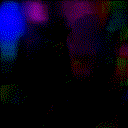

In [189]:
svid_id = 's_05_e_22_shot_000407_000481'
# svid_id = 's_02_e_28_shot_003949_004023'
svid_id = 's_04_e_22_shot_015906_015980'
somvid = complete_ds.get_video(svid_id)

test_vid = cv2.VideoCapture ('./gen_data/vis_query_val_db_train_stage1_16000_stage2_28000/' + svid_id + '.mp4')

vid_frame_data = []
while(test_vid.isOpened()):
    ret, frame = test_vid.read()
    if ret == True:
        vid_frame_data.append(frame)
    else:
        break
vid_frame_data = np.array(vid_frame_data)

angular_vals = []
flow_frames = []
hsv = np.zeros_like(vid_frame_data[0])
hsv[...,1] = 255
for i in range(1, vid_frame_data.shape[0]):
    prvs = cv2.cvtColor(vid_frame_data[i - 1], cv2.COLOR_BGR2GRAY)
    next = cv2.cvtColor(vid_frame_data[i], cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang * 180 / np.pi / 2
    angular_vals.append(hsv[...,0])
    hsv[...,2] = cv2.normalize(mag, None, 0, 255 ,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    flow_frames.append(rgb)

flow_frames_img = [pil.fromarray(f) for f in flow_frames]
flow_frames_img[0].save('flow_viz.gif', save_all=True, optimize=False, duration=42, append_images=flow_frames_img[1:])
! mogrify -loop 0  *.gif

Image(filename='./flow_viz.gif')

In [190]:
av_arr = np.array(angular_vals)

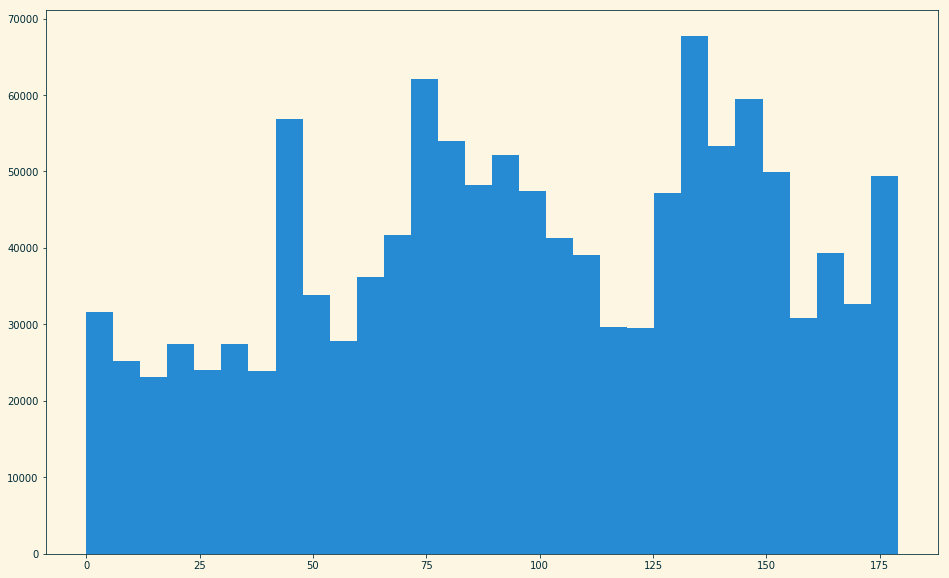

In [199]:
_ = pd.Series(av_arr.flatten()).hist(bins=30)

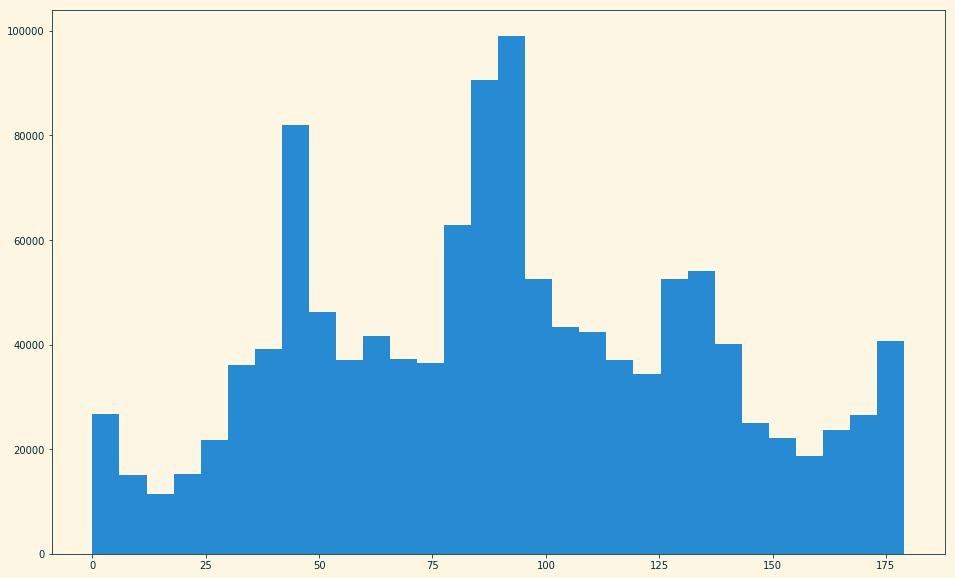

In [203]:
_ = pd.Series(av_arr.flatten()).hist(bins=30)

In [191]:
np.min(av_arr.shape)

74

In [192]:
np.max(av_arr.shape)

128

In [193]:
av_arr.mean()

97.02197265625

In [194]:
excised = np.concatenate((av_arr[:, 0:50, :], av_arr[:, 90:, :]), axis=1)

In [195]:
excised.mean()

94.732421875

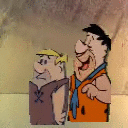

In [104]:
Image(filename='./gen_data/new_gifs/' + svid_id + '.gif')

In [112]:
fa = np.array(flow_frames)
fa.mean()

15.628402847427505

In [119]:
maybe_angle = hsv[...,0] 
maybe_angle.mean()

97.02197265625

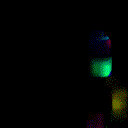

In [200]:
svid_id = 's_05_e_22_shot_000407_000481'
# svid_id = 's_02_e_28_shot_003949_004023'
# svid_id = 's_04_e_22_shot_015906_015980'
somvid = complete_ds.get_video(svid_id)

test_vid = cv2.VideoCapture ('./gen_data/vis_query_val_db_train_stage1_16000_stage2_28000/' + svid_id + '.mp4')

vid_frame_data = []
while(test_vid.isOpened()):
    ret, frame = test_vid.read()
    if ret == True:
        vid_frame_data.append(frame)
    else:
        break
vid_frame_data = np.array(vid_frame_data)
angular_vals = []
flow_frames = []
hsv = np.zeros_like(vid_frame_data[0])
hsv[...,1] = 255
for i in range(1, vid_frame_data.shape[0]):
    prvs = cv2.cvtColor(vid_frame_data[i - 1], cv2.COLOR_BGR2GRAY)
    next = cv2.cvtColor(vid_frame_data[i], cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    angular_vals.append(hsv[...,0])
    hsv[...,0] = ang * 180 / np.pi / 2
    hsv[...,2] = cv2.normalize(mag, None, 0, 255 ,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    flow_frames.append(rgb)

flow_frames_img = [pil.fromarray(f) for f in flow_frames]
flow_frames_img[0].save('flow_viz.gif', save_all=True, optimize=False, duration=42, append_images=flow_frames_img[1:])
! mogrify -loop 0  *.gif

Image(filename='./flow_viz.gif')

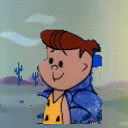

In [201]:
Image(filename='./gen_data/new_gifs/' + svid_id + '.gif')

In [202]:
av_arr = np.array(angular_vals)

In [204]:
excised = np.concatenate((av_arr[:, 0:50, :], av_arr[:, 90:, :]), axis=1)

In [188]:
excised.mean()

95.8682528409091

In [162]:
av_arr.mean()

90.84613037109375

In [163]:
maybe_angle = hsv[...,0] 
maybe_angle.mean()

90.84613037109375

improve

background motion - match direction of motion to source video

get raw_output_arrays

### 3.1.1 hide

In [ ]:
cap = cv2.VideoCapture("vtest.avi")

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

In [23]:
# while(1):
#     ret, frame2 = cap.read()
#     next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

#     flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

#     mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
#     hsv[...,0] = ang * 180/np.pi/2
#     hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
#     rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

#     cv2.imshow('frame2',rgb)
#     k = cv2.waitKey(30) & 0xff
#     if k == 27:
#         break
#     elif k == ord('s'):
#         cv2.imwrite('opticalfb.png',frame2)
#         cv2.imwrite('opticalhsv.png',rgb)
#     prvs = next

# cap.release()
# cv2.destroyAllWindows()

## 3.2 metric proposal

axes:

incorrect placement

depth ordering

scale/proportions

inconsistent pose

real vs. surreal.... violate cartoon physics

excessive flickering (at say, the body part level)

floating/disconnected characters

consistent direction of motion

duplicate characters

fade ins/outs/ shot changes

bg color mismatch

# 4. Hide

In [ ]:
# def gen_template_args_from_datapoint_v1(video):
#     description = video.description()
#     if description[-1] != '.':
#         description += '.'
#     description = description.replace('\'', '')
#     formatted_description = [[word.encode('utf8').decode() for word in sent.split()] for sent in description.split('.')][:-1]
#     return {'image_id': video.gid(), 'formatted_description': formatted_description}


In [ ]:
# test_vid = complete_ds.get_video('s_06_e_13_shot_041125_041199')

# complete_ds.get_video('s_01_e_03_shot_023155_023229').description()

# demo_vid = deepcopy(test_vid)

# # for char in demo_vid.data()['characters']:
# #     if char.data()['entityLabel'] == 'barney':
# #         char.data()['entityLabel'] = 'wilma'
# # demo_vid.data()['description'] = demo_vid.description().replace('Barney', 'Wilma')

# # demo_vid.data()['setting'] = 'kitchen'
# demo_vid.data()['characters'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').data()['characters']
# demo_vid.data()['objects'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').data()['objects']
# demo_vid.data()['parse'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').data()['parse']

# demo_vid.data()['setting'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').setting()
# demo_vid.data()['description'] = complete_ds.get_video('s_01_e_03_shot_023155_023229').description()

In [ ]:
# responses = [mt_client.create_html_hit(basic_hit_params=static_params, template_params=template_params, **gen_template_args_from_datapoint(vid)) for vid in videos]

In [ ]:
# sent_len_threshold = 30
# current_batch_short_sent = {vid: desc for vid, desc in working_corrected.items() if sent_len_threshold > len(desc.split())}
# current_batch_very_long_sent = {vid: desc for vid, desc in working_corrected.items() if sent_len_threshold <= len(desc.split())}